# Introduction / Description

In this notebook we explore the Kickstarter.com dataset, that [someone](https://webrobots.io/kickstarter-datasets/) kindly scraped for us from the Kickstarter website. We try to predict the success of the campaigns based on the data available to us.

# Setting up the environment

## Import Python packages

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

# Scikit Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, 
    accuracy_score, 
    plot_roc_curve, 
    classification_report, 
    confusion_matrix, 
    plot_confusion_matrix
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

import datetime

## Matplotlib and Pandas configurations

In [84]:
# Seting the default figure size
plt.rcParams["figure.figsize"] = (8, 5)

# Display all columns with pandas
pd.options.display.max_columns = None

## Setting a seed

In [123]:
RSEED = 42

## Loading the data

Note that the data below is not the raw data but has been preprocessed using the script `raw_convert.py`.

In [195]:
df = pd.read_csv('data/Kickstarter_preprocessed.csv')

# Data Cleaning

In [86]:
# Getting an overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 76 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         209222 non-null  int64  
 1   backers_count                      209222 non-null  int64  
 2   blurb                              209214 non-null  object 
 3   converted_pledged_amount           209222 non-null  int64  
 4   country                            209222 non-null  object 
 5   created_at                         209222 non-null  int64  
 6   currency                           209222 non-null  object 
 7   currency_symbol                    209222 non-null  object 
 8   currency_trailing_code             209222 non-null  bool   
 9   current_currency                   209222 non-null  object 
 10  deadline                           209222 non-null  int64  
 11  disable_communication              2092

In [196]:
# Deleting the first column (bears no information)
df.drop(['Unnamed: 0'],axis=1,inplace=True);

# Rename some columns to have more meaningful names
df.rename(columns={'name_category':'category_sub',
                   'slug_category':'category',
                   'blurb':'description'},
          inplace=True)

## Inspecting the target variable (the success of the projects)

In [88]:
df.state.unique()

array(['failed', 'successful', 'canceled', 'live', 'suspended'],
      dtype=object)

We have found four different categories:
- successful
- failed
- live
- suspended

We are restricting the analysis on projects which have been finished, therefore we delete all rows of the categories **canceled**, **live** and **suspended**.

In [89]:
df = df[df.state.isin(['successful','failed'])]

In [90]:
# Showing the distribution of sucessful and failed projects in the entire dataset
df.state.value_counts()

successful    117465
failed         75199
Name: state, dtype: int64

## Date format conversion

The dates are provided in the UNIX time format. For feature engineering and better intuition the date should be in the Pandas datetime format.

In [91]:
time_cols = ['created_at','deadline','state_changed_at','launched_at']
df[time_cols] = df[time_cols].applymap(lambda x: datetime.utcfromtimestamp(x))

## Basic Feature Engineering

The project descriptions might bear a lot of useful information. Howerver, natural languae processing is not in the scope of this project, so for now we will only include the length of the description as a feature.

In [92]:
df['description_length'] = df['description'].apply(lambda x: len(str(x).split()))

In order to compare the pledge goals, we convert them to USD.

In [93]:
df = df.eval('usd_goal = static_usd_rate * goal')

The duration of the projects as well as their start year and month might also be a good features or a useful variable for visualisations.

In [94]:
# Calculating the duration of project
df['duration'] = df['deadline'] - df['launched_at']
df['duration_days']=df['duration'].dt.days

# Start year and month of the projects
df['start_month']= df['launched_at'].dt.month
df['start_year']= df['launched_at'].dt.year

The project category has to be split in super- and subcategories.

In [95]:
# Splitting the text in column category, keeping only the left part of the string
df.category = df.category.apply(lambda x: x.split('/')[0])

# change to lower case string
df.category_sub = df.category_sub.str.lower()

Some variables need to be defined as categorical variables, even if they contain numbers (e.g. start month).

In [96]:
categorical_features = [
    'currency', 
    'country', 
    'staff_pick', 
    'category', 
    'category_sub',
    'start_month'
]

In [100]:
# Convert strings and numbers to categories
df[categorical_features] = df[categorical_features].apply(lambda x: x.astype('category'))
# Convert strings to numbers
df[categorical_features] = df[categorical_features].apply(lambda x: x.cat.codes)
# Convert numbers to categories
df[categorical_features] = df[categorical_features].apply(lambda x: x.astype('category'))

In [101]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192664 entries, 0 to 209221
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   description_length  192664 non-null  int64   
 1   duration_days       192664 non-null  int64   
 2   usd_goal            192664 non-null  float64 
 3   country             192664 non-null  category
 4   staff_pick          192664 non-null  category
 5   category            192664 non-null  category
 6   category_sub        192664 non-null  category
 7   start_month         192664 non-null  category
dtypes: category(5), float64(1), int64(2)
memory usage: 7.0 MB


# Data exploration

### Data preprocessing for the plots below

In [176]:
pledged_per_year_month = df.groupby(['start_year','start_month']).sum().usd_pledged.reset_index()
pledged_per_year = df.groupby(['start_year']).sum()

pledged_per_year.loc[2009,'usd_pledged']

for i in range(0,pledged_per_year_month.shape[0]):
    pledged_per_year_month.loc[i,'usd_pledged'] = pledged_per_year_month.loc[i,'usd_pledged'] / pledged_per_year.loc[pledged_per_year_month.loc[i,'start_year'],'usd_pledged']

In [177]:
durations_list = sorted(list(df.duration_days.unique()))
duration_counts = df.duration_days.value_counts()

countries_list = list(df.country.unique())

categories_list = list(df.category.unique())

In [178]:
success_per_duration_day = [len(df.query('state in ["successful"] & duration_days==@i'))/len(df.query('state in ["successful","failed"] & duration_days==@i')) for i in durations_list]

success_per_country = [[round(len(df.query('state in ["successful"] & country==@i'))/len(df.query('state in ["successful","failed"] & country==@i')),5), i] for i in countries_list]
success_per_country = np.array(sorted(success_per_country, key= lambda x: x[0]))

success_per_category = [[len(df.query('state in ["successful"] & category==@i'))/len(df.query('state in ["successful","failed"] & category==@i')), i] for i in categories_list]
success_per_category = np.array(sorted(success_per_category, key= lambda x: x[0]))

### Success in projects with and without staff pick

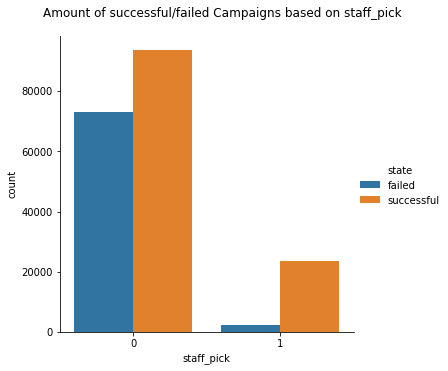

In [179]:
ax = sns.catplot(data=df.query('state in ["successful","failed"]'), x='staff_pick', hue='state', kind='count')
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle("Amount of successful/failed Campaigns based on staff_pick");

### Success rate based on the project duration

In [180]:
window_size = 2

rolling_avg = pd.Series(success_per_duration_day[0:])
windows = rolling_avg.rolling(window_size)
moving_av = windows.mean()

moving_av_list = moving_av.tolist()
without_nans = moving_av_list[window_size - 1:]

Text(0, 0.5, 'Success rate')

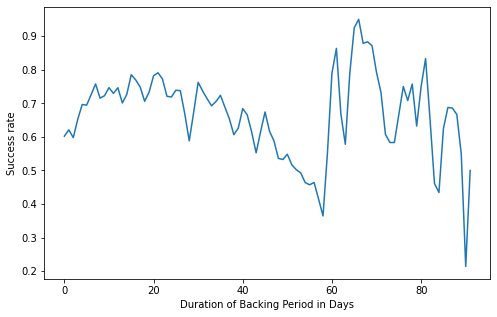

In [181]:
import matplotlib.pyplot as plt
plt.plot(range(0,len(without_nans)), without_nans)
plt.xlabel('Duration of Backing Period in Days')
plt.ylabel('Success rate')

### Success rate based on the coarse category of the project

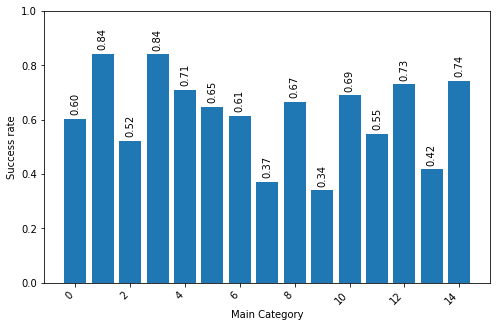

In [182]:
fig, ax = plt.subplots()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Success rate')
plt.xlabel('Main Category')
plt.ylim(0,1)
rec = ax.bar(success_per_category[:,1], height=success_per_category[:,0].astype(float))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 15), rotation=90, textcoords='offset points')

### Success rate based on the country from where the campaign has been started

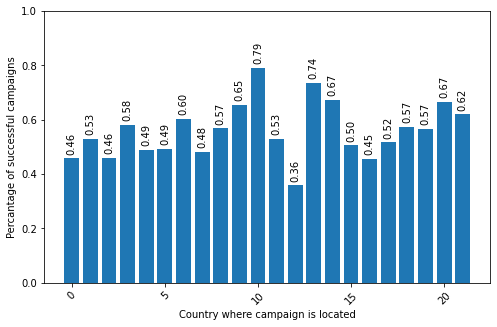

In [183]:
fig, ax = plt.subplots()
plt.xticks(rotation=45)
plt.xlabel('Country where campaign is located')
plt.ylabel('Percantage of successful campaigns')
plt.ylim(0,1)
rec = ax.bar(success_per_country[:,1], height=success_per_country[:,0].astype(float))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 15), rotation=90, textcoords='offset points')


### Success rate based on the month when the campaign was launched

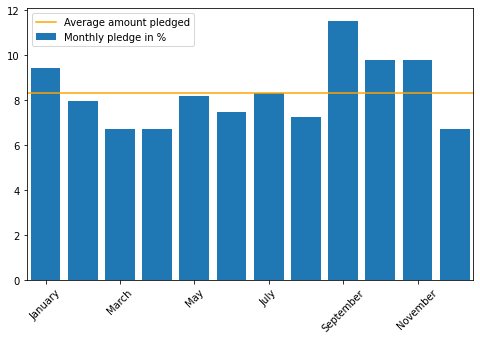

In [184]:
fig, ax = plt.subplots()
plt.xlim(-0.5,11.5)
plt.xticks([0,2,4,6,8,10],['January','March','May','July','September','November'],rotation=45)
rec = ax.bar(x=range(0,12), height=pledged_per_year_month.groupby('start_month').mean().reset_index().usd_pledged*100, label='Monthly pledge in %')
ax.plot(np.linspace(-0.5,11.5,num=13),np.mean(pledged_per_year_month.groupby('start_month').mean().reset_index().usd_pledged*100)*np.ones([13,1]), color='orange', label='Average amount pledged')
plt.legend()


from scipy.interpolate import interp1d
from scipy import interpolate

#tck = interpolate.splrep(x=range(0,12), y=pledged_per_year_month.groupby('start_month').mean().reset_index().usd_pledged, s=0)
#xnew = np.linspace(0, 11, num=100, endpoint=True)
#ynew = interpolate.splev(xnew, tck, der=0)

#f2 = interp1d(x=range(0,12), y=pledged_per_year_month.groupby('start_month').mean().reset_index().usd_pledged, kind='cubic')
#plt.plot(np.linspace(0, 10, num=100, endpoint=True), f2(np.linspace(0, 10, num=100, endpoint=True)))

#plt.plot(xnew,ynew)



# Feature selection

We judged not all features to be relevant for predicting the success of the projects. The relevant features are included below.

In [102]:
features = ['description_length','duration_days','usd_goal','country','staff_pick','category','category_sub','start_month']
target = ['state']

## Inter-feature correlation

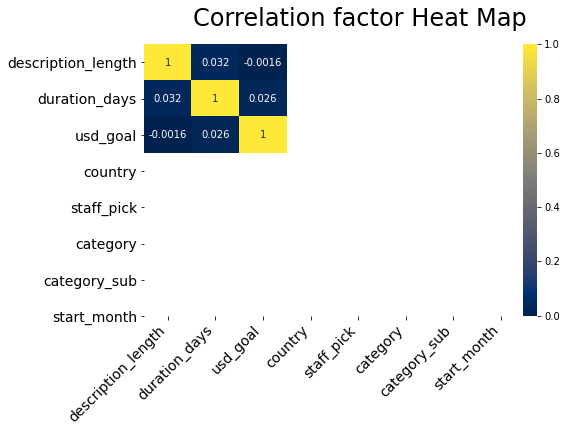

In [103]:
# Calculating the correlation matrix 
feat = df[features]
corr = feat.corr()

# Creating a plot
fig, ax = plt.subplots()
sns.heatmap(corr, xticklabels=feat.columns, yticklabels=feat.columns, annot=True,cmap='cividis')

fig.text(s="Correlation factor Heat Map",x=.5,y=0.95, fontsize = 24,ha='center', va='center')
plt.xticks(rotation=45, fontsize=14, ha='right')
plt.yticks(rotation=0, fontsize=14);

Since only a few variables are numerical in their nature, for most interactions between variables, it is not possible to calculate correlation coefficients.

## Train-test split

In [104]:
X = df[features]
y = df[target]

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set: ', X_test.shape , y_test.shape)

Train set: (144498, 8) (144498, 1)
Test set:  (48166, 8) (48166, 1)


Scikit Learn expects the labels in a different format (vector) as the features (matrix). Therefore, we are converting th labels accordingly.

In [106]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set: ', X_test.shape , y_test.shape)

Train set: (144498, 8) (144498,)
Test set:  (48166, 8) (48166,)


## One-hot encoding

In [148]:
enc = OneHotEncoder(drop='first').fit(pd.concat([X_train, X_test], axis=0))
X_train_enc = enc.transform(X_train)
X_test_enc = enc.transform(X_test)

# Predictive modelling

## Random forest classifier

In [78]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144498 entries, 107486 to 54446
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   description_length  144498 non-null  int64   
 1   duration_days       144498 non-null  int64   
 2   usd_goal            144498 non-null  float64 
 3   country             144498 non-null  category
 4   staff_pick          144498 non-null  category
 5   category            144498 non-null  category
 6   category_sub        144498 non-null  category
 7   start_month         144498 non-null  category
dtypes: category(5), float64(1), int64(2)
memory usage: 5.2 MB


In [107]:
rfc = RandomForestClassifier(max_depth=20,
                             max_features=0.5, 
                             min_samples_split=5, 
                             n_jobs=-1)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, max_features=0.5, min_samples_split=5,
                       n_jobs=-1)

Predict the target values for the test data

In [108]:
y_pred = rfc.predict(X_test)

Predict the target values for the train data

In [109]:
y_pred_train = rfc.predict(X_train)

### Print the classifictaion report and the confusion matrix on the test data

In [110]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      failed       0.77      0.71      0.74     18800
  successful       0.82      0.87      0.84     29366

    accuracy                           0.81     48166
   macro avg       0.80      0.79      0.79     48166
weighted avg       0.80      0.81      0.80     48166



### Print the classifictaion report and the confusion matrix on the training data

In [111]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

      failed       0.92      0.87      0.89     56399
  successful       0.92      0.95      0.93     88099

    accuracy                           0.92    144498
   macro avg       0.92      0.91      0.91    144498
weighted avg       0.92      0.92      0.92    144498



In [112]:
def cm_plot(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    # define figure size
    fig, ax = plt.subplots()
    # plot heatmap
    sns.heatmap(cm, cmap='cividis',ax=ax, annot=True, fmt='d', linewidths=.5)
    # adjust figure
    ax.set_xticklabels(['failed','succsessfull'])
    ax.set_yticklabels(['failed','succsessfull'])
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(rotation=45, fontsize=12)
    plt.xlabel('predicted values',fontsize=20)
    plt.ylabel('true values',fontsize=20);

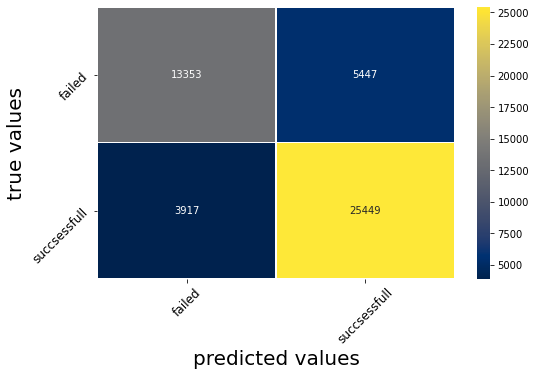

In [113]:
cm_plot(y_test,y_pred)

### Take a look on feature importance

In [117]:
def plot_feat_importance(model):
    # calculate importance
    importance = model.feature_importances_
    # set axis, create figure
    x_axis = list(range(len(importance)))
    fig, ax = plt.subplots()
    # plot figure
    plt.bar(x_axis, importance, color=['grey','lightblue'])
    # add Title
    fig.text(s="Feature importance",
             x=.5,y=0.95,
             fontsize = 20,
             ha='center', 
             va='center')
    # edit xticks
    plt.xticks(x_axis, 
               features, 
               rotation=45, 
               fontsize=14, 
               ha='right')
    #plt.yticks(rotation=0, fontsize=14);
    plt.yticks([])
    # add value inside the bars
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_height(), 
                    (p.get_x() + p.get_width() / 2., 
                     p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, -10), 
                    textcoords='offset points')

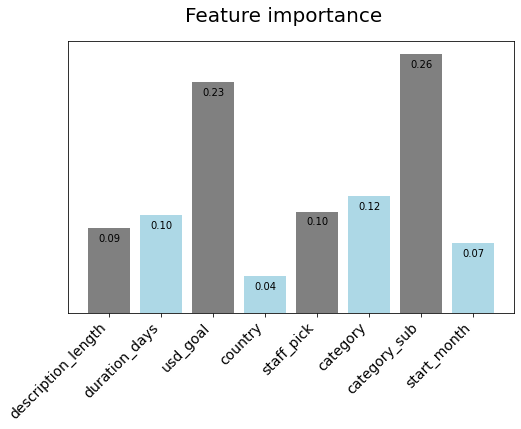

In [118]:
plot_feat_importance(rfc)

### Plot ROC curve

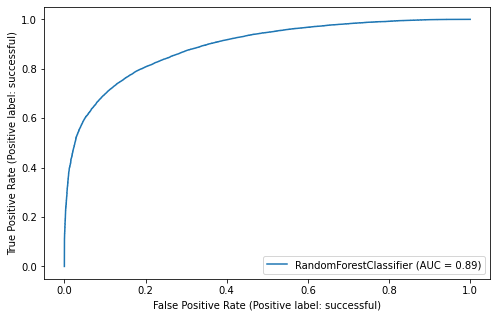

In [119]:
plot_roc_curve(rfc, X_test, y_test);

## Random forest classifier - optimization

In [125]:
# Hyperparameter grid
param_grid = {
    #'n_estimators': [100, 150, 250, 300],
    'max_depth': [None] +  [5,20,50],
    'max_features': ['sqrt', None, 0.5],
    #'max_leaf_nodes': [None] + [10, 50, 200],
    'min_samples_split': [5, 10]
    #'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = GridSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        verbose = 5)

# Fit 
rs.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 20, 50],
                         'max_features': ['sqrt', None, 0.5],
                         'min_samples_split': [5, 10]},
             scoring='roc_auc', verbose=5)

### Best parameters

In [129]:
rs.best_params_

{'max_depth': 20, 'max_features': None, 'min_samples_split': 5}

In [130]:
opt_model = rs.best_estimator_
y_pred_opt = opt_model.predict(X_test)

### Compare base model and optimized model, state nodes and maximum depth

In [141]:
def rf_properties(model):
    n_nodes=[]
    max_depths=[]
    for ind_tree in model.estimators_:
        n_nodes.append(ind_tree.tree_.node_count)
        max_depths.append(ind_tree.tree_.max_depth)
    print(f'Average number of nodes {int(np.mean(n_nodes))}')
    print(f'Average maximum depth {int(np.mean(max_depths))}')

In [143]:
# Properties of the un-optimized random forest classifier
rf_properties(rfc)

Average number of nodes 18521
Average maximum depth 20


In [145]:
# Properties of the optimized random forest classifier
rf_properties(opt_model)

Average number of nodes 16760
Average maximum depth 20


### Plot ROC curve

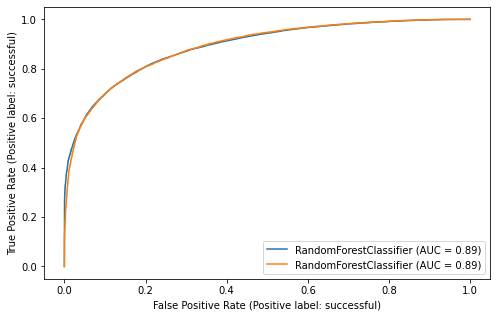

In [146]:
ax = plt.gca()
plot_roc_curve(opt_model, X_test, y_test,ax=ax);
plot_roc_curve(rfc, X_test, y_test,ax=ax);

### Saving the optimized model

In [189]:
filename = 'optimized_random_forest_model.pickle'
with open(filename, 'wb') as file:
    pickle.dump(opt_model, file)

### Loading the model again

In [190]:
with open(filename, 'rb') as file:
    opt_model_loaded = pickle.load(file)

In [193]:
opt_model

RandomForestClassifier(max_depth=20, max_features=None, min_samples_split=5,
                       random_state=42)

In [192]:
opt_model_loaded

RandomForestClassifier(max_depth=20, max_features=None, min_samples_split=5,
                       random_state=42)

## XGBoost Classifier

For the XGBoost Classifier we need our features to be 'one-hot encoded', as there is no support for categorical variables (see above).

In [151]:
xgb_model = XGBClassifier()

In [153]:
xgb_model.fit(X_train_enc, y_train)

/home/mario/neuefische/ML_Classification_Kickstarter/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:38:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [154]:
y_pred = xgb_model.predict(X_test_enc)

In [155]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      failed       0.70      0.77      0.74     18800
  successful       0.84      0.79      0.82     29366

    accuracy                           0.78     48166
   macro avg       0.77      0.78      0.78     48166
weighted avg       0.79      0.78      0.78     48166



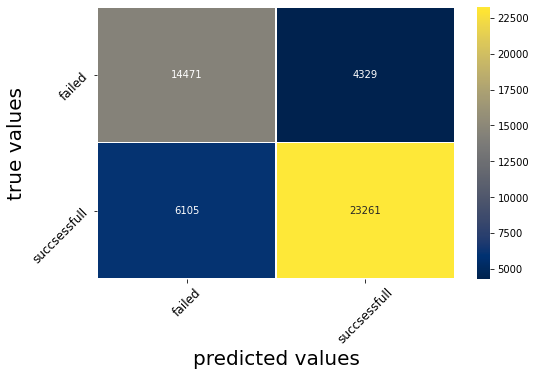

In [158]:
cm_plot(y_test, y_pred)

## XGBoost Classifier

Optimizing the XGBoost Classifier did not lead to much better predictions and the prediction scores were slightly worse than those from the random forest model.

## KNN Classifier

The KNN classifier works much better with 'one-hot encoded' variables because only those can properly represent the true distances between data points.

In [161]:
# With default parameters (5 neighbours, uniform weighting, see docstring for more)
knn = KNeighborsClassifier()
knn.fit(X_train_enc,y_train)

KNeighborsClassifier()

In [162]:
y_pred = knn.predict(X_test_enc)

Print the classifictaion report and the confusin matrix

In [163]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      failed       0.67      0.66      0.67     18800
  successful       0.79      0.80      0.79     29366

    accuracy                           0.74     48166
   macro avg       0.73      0.73      0.73     48166
weighted avg       0.74      0.74      0.74     48166



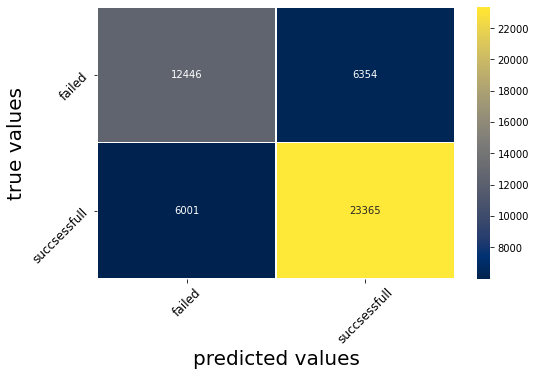

In [164]:
cm_plot(y_test,y_pred)

Still to do: find the optimal number of neighbours for the KNN classifier via a grid search.